In [79]:
correspondanceDict = {
    'E': 0,
    'P': 1,
    'O': 2,
    'T': 3
}

class Cell:
    """
    A building block of the grid. Contains:
    - status (one out of {E, P, O, T})
    - numeric status: E = 0, P = 1, O = 2, T = 3
    - coordinates (x,y)
    - cost function value
    
    """
    def __init__(self, x, y, status = "E"):
        self.status = status #by default, a cell is empty
        self.num_status = correspondanceDict[status]
        self.x = x #setting coordinate x
        self.y = y #setting coordinate y
        self.cost = 0 #by default we set costfunction to zero 
          
    def info(self):
        """
        prints cell info
        
        """
        print("=================")
        print("Cell status: " + str(self.status))
        print("Cell numStatus:" + str(self.num_status))
        print("Cell coordinates:(" + str(self.x) + "," + str(self.y) + ")")
        print("Cell utility:" + str(self.cost))
        print("=================")
        
    def change_status(self, new_status):
        self.status = new_status
        self.num_status = correspondanceDict[new_status]
        
class Pedestrian(Cell):
    """
    this class will permit to record additional information for the pedestrians. Indeed, here we also have:
    -itinerary: every time pedestrian makes a move, it is recorded here
    -speed: amount of cells that can be traversed in a single time shift

    """
    
    def __init__(self, x, y, status = "E", speed = "1"):
        Cell.__init__(self, x, y, status)
        self.itinerary = list()
        self.itinerary.append(Cell(x,y,'E'))
        self.speed = speed
        
    def append_cell_itinerary(self, x, y):
        """
        Adds cell with specified coordinates to the itinerary
        """
        self.itinerary.append(Cell(x,y, "E"))
        self.x = x
        self.y = y
        
    def info(self):
        print("=================")
        print("Pedestrian.")
        print("Coordinates:(" + str(self.x) + "," + str(self.y) + ")")
        print("=================")
        
    

In [80]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors 
class Grid:
    """
    The working environment. Supports both manual and file initialization (has to be done explicitly).
    Contains:
    - xdim: how many cells on x-axis
    - ydim: how many cells on y-axis
    - cells: cells of the grid. Numpy array.
    - targets: list of target cells. Initially empty
    - obstacles: list of obstacle cells. Initially empty
    - pedestrians: list of pedestrians. Initially empty
    """
    
    
    ####################################################################
    ########           Setting up the environment       ################
    ####################################################################
    
    def __init__(self, xdim, ydim):
    
        #initialize dimensions:
        self.xdim = xdim 
        self.ydim = ydim
        
        #initialize cell lists:
        self.targets = list()
        self.obstacles = list()
        self.pedestrians = list()
        
        #initialize cells:
        self.cells = list()
        for i in range(self.xdim*self.ydim):
            self.cells.append(Cell(int(i%self.xdim), int(i/self.xdim), 'E'))
        self.cells = np.array(self.cells)  
        
        
        #read configuration from file
        file = open("test1.txt", "r")
        line = file.readline()
        status, x, y = line.split(" ")
        while(line):
            status, x, y = line.split(" ")
            self.add_item(status,int(x),int(y))
            line = file.readline()
        file.close()  
        
        #Collect information about targets, pedestrians and obstacles
        for i in range(len(self.cells)):
            if self.cells[i].status == "O":
                self.obstacles.append(self.cells[i])
            elif self.cells[i].status == "T":
                self.targets.append(self.cells[i])
            elif self.cells[i].status == "P":
                self.pedestrians.append(Pedestrian(self.cells[i].x, self.cells[i].y, 'P'))
            else:
                continue
        
        #setting utility values
        self.set_utility()
        
        
    def visualize_map(self):
        """
        visualize current state of the environment
        
        """
        #extract numeric status from cells, save in data
        cells_num_status = list()
        for i in range(len(self.cells)):
            cells_num_status.append(self.cells[i].num_status)
        data = np.array(cells_num_status).reshape(self.xdim, self.ydim)
        
        # create discrete colormap
        cmap = colors.ListedColormap(['white', 'blue', 'red', 'yellow'])
        bounds = [0,1,2,2.5,3]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        #visualize
        fig, ax = plt.subplots(figsize=(10,10))
        ax.imshow(data, cmap=cmap, norm=norm)
        ax.set_xlim(-0.5,self.xdim-0.5)
        ax.set_ylim(-0.5,self.ydim-0.5)
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
        ax.set_xticks(np.arange(-.5, self.xdim-0.5, 1));
        ax.set_yticks(np.arange(-.5, self.ydim-0.5, 1));
        plt.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelleft=False,
            labelbottom=False) # labels along the bottom edge are off
        plt.savefig("vis.png")
        plt.show()
        
    def visualize_map_patterns(self):
        """
        visualize current state of the environment plus patterns of each 
        pedestrian made by them from the beginning of the simulation
        and up to the current state
        
        """
        #mark pattern cells
        cells_copy = self.cells
        pattern_cells = list()
        for pedestrian in self.pedestrians:
            if(len(pedestrian.itinerary) > 0):
                for cell in pedestrian.itinerary:
                    pattern_cells.append(cell)
        pattern_indices = list()
        pedestrian_indices = list()

        for cell in pattern_cells:
            pattern_indices.append(cell.x + cell.y*self.xdim)
        for cell in self.pedestrians: 
            pedestrian_indices.append(cell.x + cell.y*self.xdim)
            
        pattern_indices = set(pattern_indices).difference(set(pedestrian_indices))        
            
        #extract numeric status from cells, save in data
        cells_num_status = list()
        for i in range(len(self.cells)):
            cells_num_status.append(cells_copy[i].num_status)
        for index in pattern_indices:
            cells_num_status[index] = 4
    
        # create discrete colormap
        cmap = colors.ListedColormap(['white', 'blue', 'red', 'yellow', 'orange'])
        bounds = [0,1,2,3,3.5,4]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        data = np.array(cells_num_status).reshape(self.xdim, self.ydim)
        #visualize
        fig, ax = plt.subplots(figsize=(10,10))
        ax.imshow(data, cmap=cmap, norm=norm)
        ax.set_xlim(-0.5,self.xdim-0.5)
        ax.set_ylim(-0.5,self.ydim-0.5)
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
        ax.set_xticks(np.arange(-.5, self.xdim-0.5, 1));
        ax.set_yticks(np.arange(-.5, self.ydim-0.5, 1));
        plt.tick_params(
            axis='both',       # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelleft=False,
            labelbottom=False) # labels along the bottom edge are off
        plt.savefig("vis_pat.png")
        plt.show()
        
    def add_item(self, status, x, y):
        """
        for arbitrary status, this function can be used
        """
        cell_num = self.xdim*y + x
        self.cells[cell_num].change_status(status)   
        
    #********************************************************************#
    #******* Different utilities, from simplest to most difficult *******#
    #********************************************************************#
        
    def naive_utility(self, x, y):
        """
        computes the naive utility of a cell - euclidean distance to the nearest target
        x - coordinate X of the cell
        y - coordinate Y of the cell
        
        """
        minimum = math.sqrt((x-self.targets[0].x)**2 + (y-self.targets[0].y)**2)
        for cell in self.targets:
            dist = math.sqrt((x-cell.x)**2 + (y-cell.y)**2)
            if dist < minimum:
                minimum = dist
            else:
                continue
        return minimum
    
    def utility_pedestrians(self, x, y):
        """
        computes utility bearing in mind the presence of other pedestrians
        
        """
        TARGET_COEFF = 1.0
        FEAR_COEFF   = 1.0
        #first, compute utility in function of proximity of the closest target
        minimum = math.sqrt((x-self.targets[0].x)**2 + (y-self.targets[0].y)**2)
        for cell in self.targets:
            dist = math.sqrt((x-cell.x)**2 + (y-cell.y)**2)
            if dist < minimum:
                minimum = dist
            else:
                continue
                
        #second, compute utility in function of proximity of other pedestrians
        r_critical = 2 #adjustable parameter
        distances = list()
        for pedestrian in self.pedestrians:
            if (pedestrian.x == x and pedestrian.y == y):
                continue #cuz then it's the current pedestrian
            else: 
                distances.append(math.sqrt((x-pedestrian.x)**2 + (y-pedestrian.y)**2))
        pedestrian_cost = 0
        for distance in distances:
            if distance >= r_critical:
                continue
            else:
                pedestrian_cost += math.exp(-1.0/(distance**2-r_critical**2))
        return minimum*TARGET_COEFF + pedestrian_cost*FEAR_COEFF      
        
    def utility_to(self, x, y):
        """
        computes utility bearing in mind the presence of other pedestrians and obstacles
        
        """
        TARGET_COEFF = 1.0
        FEAR_COEFF   = 1.0
        OBSTACLE_COEFF = 10**5 
        #first, compute utility in function of proximity of the closest target
        minimum = math.sqrt((x-self.targets[0].x)**2 + (y-self.targets[0].y)**2)
        for cell in self.targets:
            dist = math.sqrt((x-cell.x)**2 + (y-cell.y)**2)
            if dist < minimum:
                minimum = dist
            else:
                continue
                
        #second, compute utility in function of proximity of other pedestrians
        r_critical = 2 #adjustable parameter
        distances = list()
        for pedestrian in self.pedestrians:
            if (pedestrian.x == x and pedestrian.y == y):
                continue #cuz then it's the current pedestrian
            else: 
                distances.append(math.sqrt((x-pedestrian.x)**2 + (y-pedestrian.y)**2))
        pedestrian_cost = 0
        for distance in distances:
            if distance >= r_critical:
                continue
            else:
                pedestrian_cost += math.exp(-1.0/(distance**2-r_critical**2))

        #third, add obstacle avoidance
        isobstacle = 0
        if self.cells[x+y*self.xdim].status == 'O':
            isobstacle = 1
            
        return minimum*TARGET_COEFF + pedestrian_cost*FEAR_COEFF+isobstacle*OBSTACLE_COEFF
    
    def utility_dijkstra(self):
        """
        floods cells with the shortest distances to nearest target cell
        by using Dijkstra's algorithm
        """
        distance_arrays = list()
        for target in self.targets:
            distance_arrays.append(self.dijkstra_shortest(target.x, target.y))
            
        distances = list()
        for i in range(len(distance_arrays[0])):
            i_dist = list()
            for j in range(len(distance_arrays)):
                i_dist.append(distance_arrays[j][i])
            distances.append(min(i_dist))
        return distances
    
    def dijkstra_shortest(self, x, y):
        """
        implements dijkstras algorithm to find shortest distance to given target
        """
        #*****initializing variables
        
        #we will store visited nodes in here
        visited = [0]*(self.xdim*self.ydim)
        #obstacles will not be visited, so we will mark them as visited right away
        for obstacle in self.obstacles:
            visited[obstacle.x + obstacle.y*self.xdim] = 1 
            
        #here we will store distances
        distances = [self.xdim*self.ydim*10**3]*(self.xdim*self.ydim)
        distances[x + y*self.xdim] = 0
        
        while(sum(visited) != self.xdim*self.ydim): #while there are unvisited nodes
            #find unvisited node with minimal distance
            indx_min = -1
            min_dist = self.xdim*self.ydim*10**5
            for indx in range(len(visited)):
                if visited[indx] == 0 and distances[indx] < min_dist:
                    indx_min = indx
                    min_dist = distances[indx]
                    
            visited[indx_min] = 1 #now it is visited
            x_vis = int(indx_min%self.xdim) #coordinate X of point in question
            y_vis = int(indx_min/self.xdim) #coordinate Y of point in question 
            #print('now at: (' + str(x_vis) + " ," + str(y_vis) + ")" )
            #defining possible neighbours - obstacles excluded
            neighbours = list()
            if y_vis > 0:
                neighbours.append(self.cells[x_vis + (y_vis-1)*self.xdim])
            #top neighbour
            if y_vis < self.ydim - 1:
                neighbours.append(self.cells[x_vis + (y_vis+1)*self.xdim])
            #left neighbour
            if x_vis > 0:
                neighbours.append(self.cells[x_vis-1 + y_vis*self.xdim])
            #right neighbour
            if x_vis < self.xdim-1:
                neighbours.append(self.cells[x_vis+1 +y_vis*self.xdim])
            
            #leave only empty cells in accessible neighbours
            available_neighbours = list()
            for nb in neighbours:
                if nb.status is not "O" and visited[nb.x + nb.y*self.xdim] == 0:
                    available_neighbours.append(nb)
                    
            #updating distances
            for nb in available_neighbours:
                if distances[nb.x + nb.y*self.xdim] > distances[x_vis + y_vis*self.xdim] + 1:
                    distances[nb.x + nb.y*self.xdim] = distances[x_vis + y_vis*self.xdim] + 1
        return distances
        
        
    def set_utility(self):
        """
        Compute utility function after initializing the environment. Currently uses naive utility
        
        """
        #======================================================#
        #  Uncomment this part for dijkstra utility   #
        #======================================================#
        distances = self.utility_dijkstra()
        for cell in self.cells:
            cell.cost = distances[cell.x + cell.y*self.xdim]
        #======================================================#
        #  Uncomment this part for before-dijkstra utilities   #
        #  Then pick a utility function and use it insteat of  #
        #                   self.utility_to                    #
        #======================================================#
#         for cell in self.cells:
#             cell.cost = self.utility_to(cell.x, cell.y)
    
        
            
    ####################################################################
    ########            Evolution of the system         ################
    ####################################################################
    
    def choose_direction(self, x, y):
        """
        for a pedestrian in the cell with coordinates x,y proposes the best 
        direction to go to according to the utility function.
              !!!   Assumption is that people cannot move diagonally !!!
        returns coordinates of the suggested direction (x,y)
        """
        #
        
        #defining neighbours
        neighbours = list() #here we will store neighbours INDICES!
        #bottom neighbour
        if y > 0:
            neighbours.append(x + (y-1)*self.xdim)
        #top neighbour
        if y < self.ydim - 1:
            neighbours.append(x + (y+1)*self.xdim)
        #left neighbour
        if x > 0:
            neighbours.append(x-1 + y*self.xdim)
        #right neighbour
        if x < self.xdim-1:
            neighbours.append(x+1 +y*self.xdim)
            
        empty_neighbours = list()
        for i in range(len(neighbours)):
            if(self.cells[neighbours[i]].status == "E"):
                empty_neighbours.append(self.cells[neighbours[i]])
            if(self.cells[neighbours[i]].status == "T"):
                return -1, -1 #means we achieved target
    
        if len(empty_neighbours) > 0:
            result = empty_neighbours[0]
            for i in range(1, len(empty_neighbours)):
                if empty_neighbours[i].cost < result.cost:
                    
                    result = empty_neighbours[i]
                else:
                    continue
            
            return result.x, result.y
        else:
            return -1, -1
    
    def evolution_oper(self):
        """
        This function emulates evolution of the system. First, naive approach, supposes abscence of any obstacles
        in the presence of only one pedestrian. 
        
        """
        self.set_utility() #recomputing utility, important 
        for pedestrian in self.pedestrians:
            x_chosen, y_chosen = self.choose_direction(pedestrian.x, pedestrian.y)
            #print("chosen: " + str(x_chosen) + " " + str(y_chosen))
            if (x_chosen is not -1 and y_chosen is not -1): #if pedestrian can advance
                self.cells[pedestrian.x+pedestrian.y*self.xdim].change_status("E")
                self.cells[x_chosen + y_chosen*self.xdim].change_status("P")
                pedestrian.append_cell_itinerary(x_chosen, y_chosen)
            else: #else, move to the next pedestrian
                continue

        
        
        
        
            
        

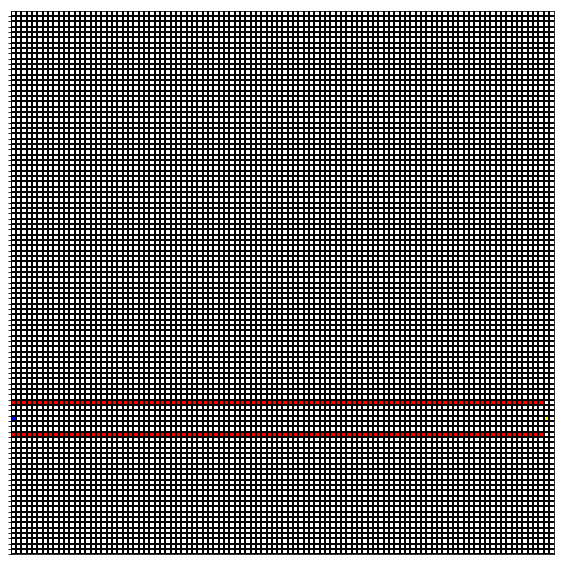

In [72]:
a = Grid(102,102)
a.visualize_map()


In [75]:
for i in range(99):
    a.evolution_oper()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


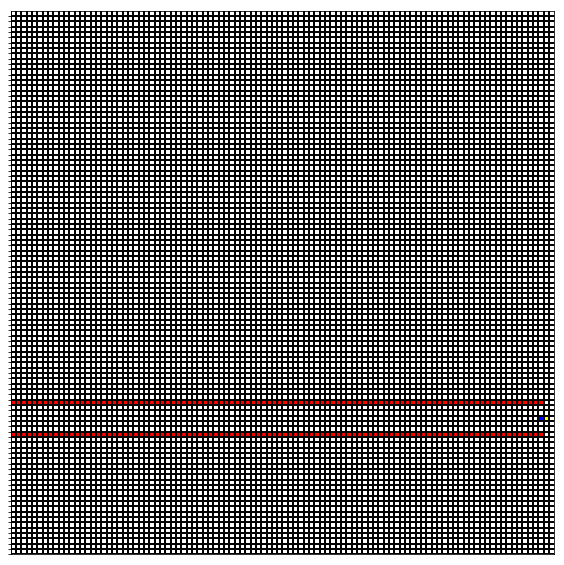

In [76]:
a.visualize_map()

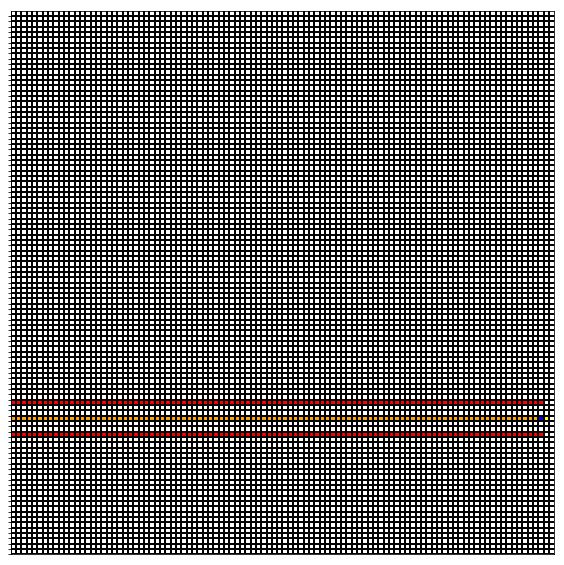

In [77]:
a.visualize_map_patterns()